In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [37]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad = other * self.data ** (other - 1) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), "tanh")
        def _backward():
            self.grad += (1 - out.data **2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return self - other

    def __rmul__(self, other):
        return self * other
    
    def __repr__(self):
        return f"Value(data = {self.data})"

In [38]:
v = Value(10)
v**2

Value(data = 100)

In [39]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [40]:
class Neuron:
    def __init__(self, nin):
        self.weights = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(np.random.uniform(-1, 1))
    
    def __call__(self, x):
        s = sum((xi * wi for xi, wi in zip(x, self.weights)), self.bias)
        s = s.tanh()
        return s

    def parameters(self):
        return self.weights + [self.bias]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts:list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [47]:
n = MLP(3, [4, 4, 1])

In [48]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
out = n(x)
out

Value(data = -0.7777809079209986)

In [49]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [50]:
for k in range(200):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))


    #backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    for p in n.parameters():
        p.data -= 0.01 * p.grad
    if not k % 10:
        print(k, loss.data)

0 6.195540589113157
10 1.749941159923938
20 0.5213219322649771
30 0.27419828982790034
40 0.17635685413476498
50 0.12644629319480513
60 0.09699119903780526
70 0.07787087026245514
80 0.06460020137703196
90 0.05492259273085501
100 0.04759216083256356
110 0.04187045375253699
120 0.03729457759557584
130 0.03356092856810646
140 0.03046279549742644
150 0.027854953532532634
160 0.025632615534997995
170 0.023718414554274883
180 0.022054075097283972
190 0.02059492485435014


In [45]:
[n(x) for x in xs]

[Value(data = 0.9186412808708077),
 Value(data = -0.9260250336747393),
 Value(data = -0.8927429809021254),
 Value(data = 0.8970508290197005)]

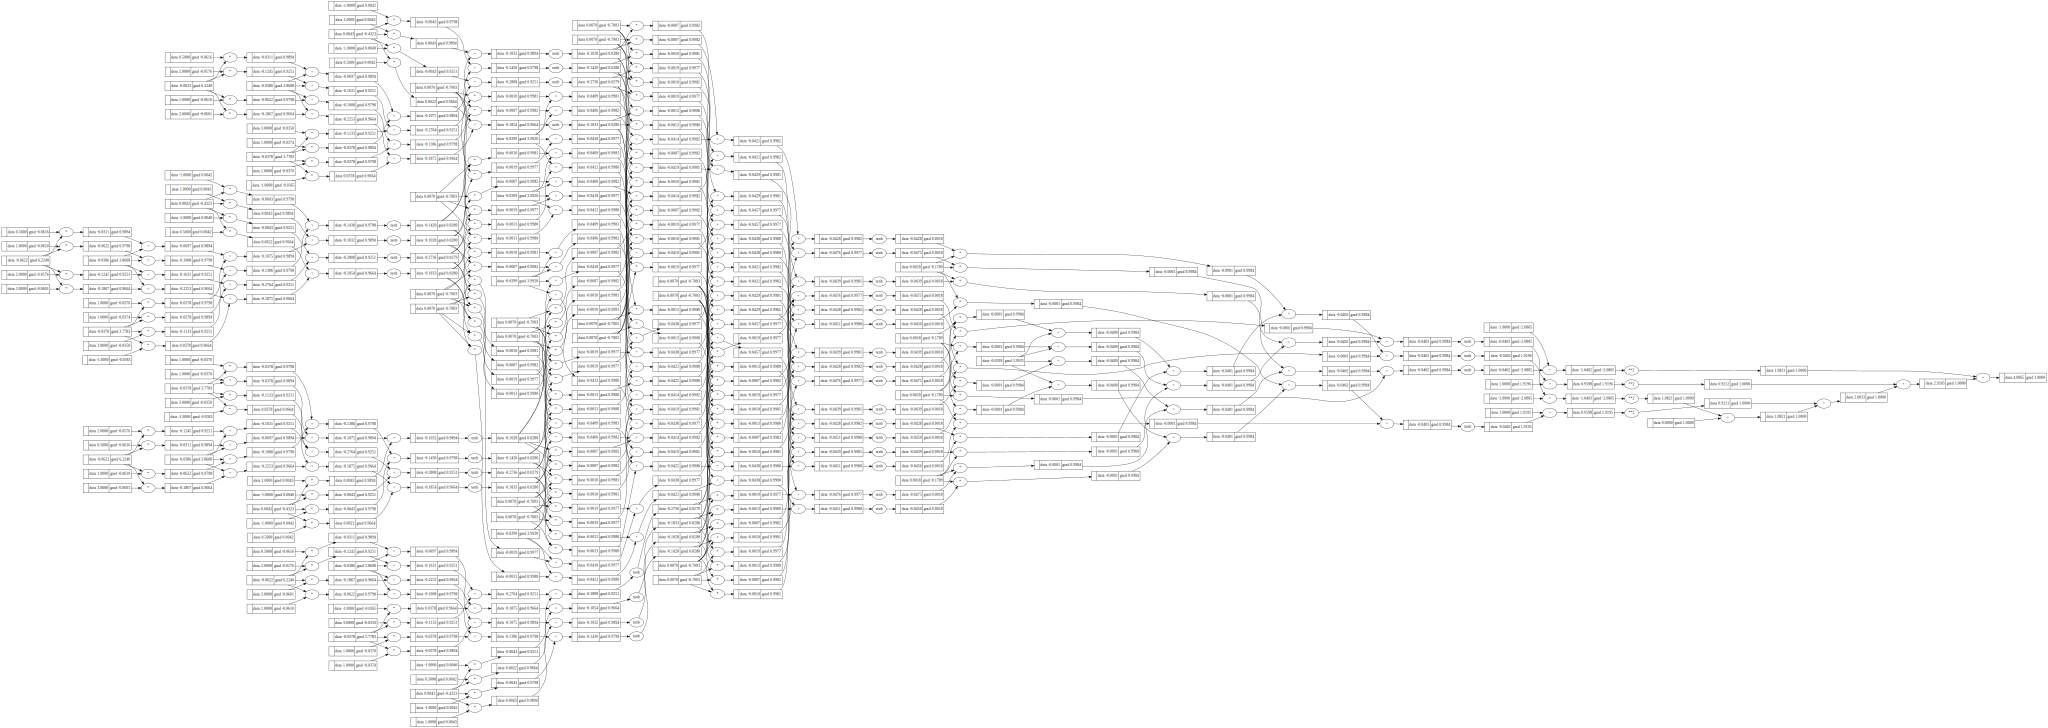

In [161]:
draw_dot(loss)

In [36]:
neuron.bias

Value(data = -0.9043734063074906)

In [37]:
neuron.parameters()

[Value(data = -0.2932154213741782),
 Value(data = 0.457305821655994),
 Value(data = -0.8674670491930043),
 Value(data = -0.9043734063074906)]